# IN-STK5000 - Medical project
#### Group 9: Anette Fredriksen, Adrian Eriksen and Maren Aamodt

## Part 1: Historical data
For part one, we are going to study the historical data set. 

In the dataset we have $x_1$ referring to the gender, 0 or 1.

$x_2$ refers to smoking, and we are assuming that $x_2 = 0$ means the person is a non-smoker, and $x_2=1$ means the person smokes.

The rest of the hisorical dataset is $x_{3:128}$ referring to the gene data, and $x_{129:130}$ referring to the symptoms.

In [2]:
#Importing necessary packages:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

In [3]:
features = pandas.read_csv('../../data/medical/historical_X.dat', header=None, sep=" ").values
actions = pandas.read_csv('../../data/medical/historical_A.dat', header=None, sep=" ").values
outcome = pandas.read_csv('../../data/medical/historical_Y.dat', header=None, sep=" ").values

In [4]:
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [5]:
df_obs = pandas.DataFrame(observations)
df_obs["symptoms"] = labels
#df_obs.head()

### The distributions of sex and smokers

Firstly, we take a closer look at the two first features, $x_1$, sex, and $x_2$, smoker, and how they are distributed in the historical data.

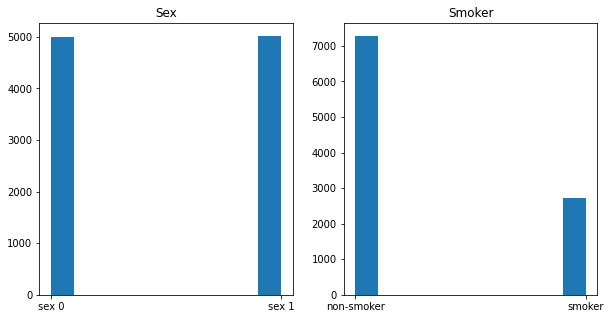

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(["sex 0", "sex 1"])
axs[0].hist(df_obs[0])
axs[0].set_title("Sex")

axs[1].set_xticks([0,1])
axs[1].set_xticklabels(["non-smoker", "smoker"])
axs[1].hist(df_obs[1])
axs[1].set_title("Smoker")

plt.show()

From the histograms, we can see that the observations seems to be equally distributed when it comes to gender.
Furtheron, we can see that there are far less smokers than non-smokers in the dataset.

Also, it would be interesting to see if there is any differences between the genders when it comes to smoking. Therefore we are plotting histograms of non-smokers and smokers given a certain gender. 

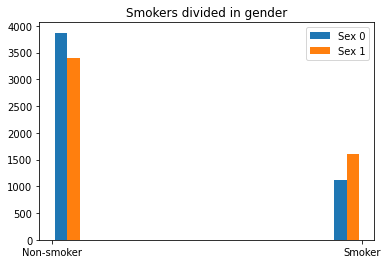

In [7]:
fig, ax = plt.subplots()

ax.hist([df_obs[1][df_obs[0]==0], df_obs[1][df_obs[0]==1]], stacked=False, label=["Sex 0", "Sex 1"])
ax.set_title("Smokers divided in gender")
ax.set(xticks=[0,1], xticklabels=["Non-smoker", "Smoker"])
ax.legend()
plt.show()

Intrestingly, it seems to be fewer smokers among "sex 1".

### Gene distributions
Next, we take a look at the distributions of $x_{3:128}$, e.g. the gene observations. Since all the genes are represented as 0 or 1, which we interpret to meaning absence or presence of gene, it is hard to visualize in a good way. 

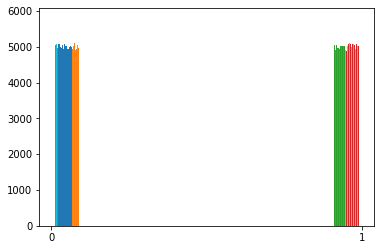

In [8]:
fig, ax = plt.subplots()
ax.hist(observations[:,2:128])
ax.set_xticks([0,1])

plt.show()

The first plot is a histogram of all the 128 genes' value. It does not give much information, except that the ratio of presence and absence of genes seems to be pretty equal for all genes.

To see the distribution clearer, we "zoom in" to see the sum of observations where a certain gene (from $x_3$ to $x_{128}$) is present (e.g. $x_i=1$). 

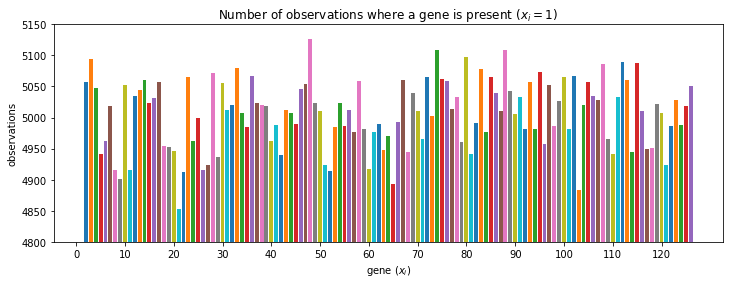

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
for i in range(2,127):
    ax.bar(i, sum(df_obs[i]==1))
    
ax.set_xlabel("gene ($x_i$)")
ax.set_xticks(np.arange(0,128,10))

ax.set_title("Number of observations where a gene is present ($x_i = 1$)")
ax.set_ylabel("observations")
ax.set_ybound(4800,5150)
plt.show()

## The symptoms

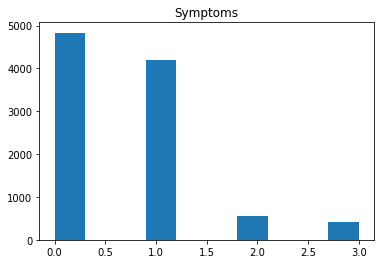

In [10]:
plt.hist(df_obs["symptoms"])
plt.title("Symptoms")
plt.show()


Looking into if there are spesific characteristics that are more common for people with symptoms.

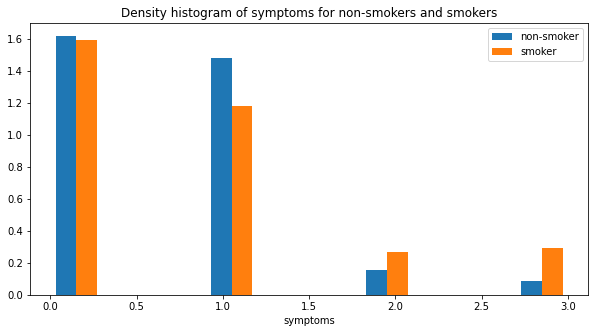

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist([labels[df_obs[1]==0],labels[df_obs[1]==1]], 
        stacked=False,
        label=["non-smoker","smoker"],
        density=True)
ax.legend()
ax.set(title="Density histogram of symptoms for non-smokers and smokers", xlabel="symptoms")
plt.show()

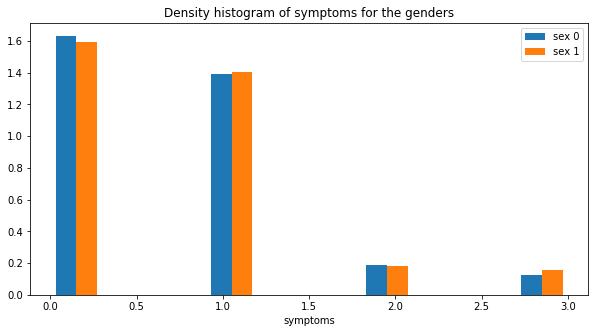

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist([labels[df_obs[0]==0],labels[df_obs[0]==1]], 
        stacked=False,
        label=["sex 0","sex 1"],
        density=True)
ax.legend()
ax.set(title="Density histogram of symptoms for the genders", xlabel="symptoms")
plt.show()

It appears to be some differences in the gene observations for the different symptoms.

### Correlations 
To understand the observations' importance, we can look at the correlation between observations and symptoms.

First, we plot the correlation matrix which vizualizes the correlations between all the observations to see if there is any significant factors.

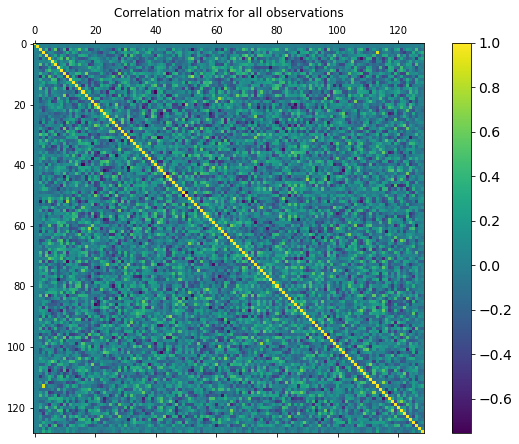

In [15]:
fig = plt.figure(figsize=(10, 7))
plt.matshow(df_obs.corr(), fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation matrix for all observations')
plt.show()

From the plot, it seems very few factors have a strong correlation with each other. 
Now we look closer at the correlation between the observations and the symptoms:

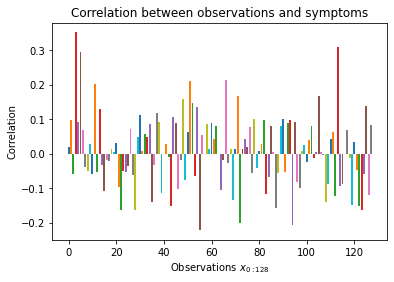

In [16]:
corrs = df_obs.corr()
for i in range(0,len(corrs['symptoms'])-1):
    plt.bar(i, corrs['symptoms'][i])
plt.title('Correlation between observations and symptoms')
plt.ylabel('Correlation')
plt.xlabel('Observations $x_{0:128}$')
plt.show()

It seems none of the observations have a very strong correlation with the symptoms. Finding max correlation:

In [17]:
print(np.max(corrs['symptoms'][0:128]))

0.35117416692278663


The largest correlation is 0.35, which is not significant.

### Single-cause or multiple-cause

#### Assumptions

We assume all the samples i.e patients are independent. 

We assume (and can see) that there is no negative variables.

#### Variable selection


To find wheter a single-casue or multiple-cause metod is best we look at the importance of variables. 
We are using code from https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
With this we are using Chi-squared test, this is a test well suited for classification tasks. Chi-squared test 

To know how many and which variables that are important we measure p-value. The variables with low p-value are assumed to have significant impact of the result.

We are selecting the best features with univariate selection and test the significance level. If one of the features is much more important than the other features we might want to use a single-cause model with that feature. 
If the dirstibution is more even we sould use multiple features. Since we have a lot of variables (since there is many genes) the model will probablty perform worse having all the features in the model. 

In [18]:
col_names = ["sex", "smoker"] +  [f"gene_{i}" for i in range(1, 127)] 

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = pd.DataFrame(features[:, :128], )
X.columns = col_names
y = labels
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

value = np.argsort(fit.pvalues_)
print("Variable and p-value with significase level < 0.05")
counter = 0
for val in value:
    if (fit.pvalues_[val] < 0.05): #using a significant level of 0.05
        counter += 1
        print(val, fit.pvalues_[val])
    else:
        break
print("Number of significant variables: ", counter)

        Specs        Score
5      gene_4  1607.259121
3      gene_2  1022.322937
11    gene_10   844.897073
113  gene_112   750.112793
72    gene_71   725.595534
83    gene_82   693.903505
52    gene_51   679.929098
55    gene_54   601.236105
94    gene_93   595.055147
108  gene_107   590.289264
69    gene_68   590.267549
112  gene_111   501.366817
66    gene_65   496.525700
51    gene_50   492.120225
71    gene_70   470.537808
126  gene_125   379.932019
87    gene_86   378.487677
4      gene_3   367.407838
115  gene_114   363.740412
2      gene_1   312.487137
Variable and p-value with significase level < 0.05
5 0.0
3 2.585551279704234e-221
11 7.92112513842356e-183
113 2.85205422421341e-162
72 5.913115783530239e-157
83 4.405371019432049e-150
52 4.7215169520263293e-147
55 5.43778158197959e-130
94 1.1894967328702515e-128
108 1.2838711181758232e-127
69 1.2978624713694134e-127
112 2.412462043655602e-108
66 2.7014512265637414e-107
51 2.4339210994403284e-106
71 1.1565662527394446e-101
126 4.

From the feature selection we can se that the genes are more influential than gender and if a person smokes. When printing all the vales we can se that gender has a score of 3.1 and has the third least stronges relationship with symptoms. Smoker has a score of 194.2 and is the 31 most influential variable. It is a big difference in scores for different genes. 

From the test of significance, we have 120 variables with p-value less than 0.05. This is almost all the variables and we might want to set the threshold for p-value down, to get a more sparse model. 

### Mutual Information Feature Selection

To be more sure of which variables we can/sould remove we should check if another methods gives some of the same result. We use Mutual Information to find the best scores using sklearn, the values from a variables score are very close to 0 the variable does not reduce the uncertanty of whether a patient has a symptom or not. We remove the lowest scores (lower than 0.005) and print the variables with the highest scores in a sorted order from highest to lowest.

Here the assumptions are also that the dataset contains no negative values. 

Inspired from this articele: https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [33]:
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all').fit(X, y)
fs_sort = np.argsort(fs.scores_)
scores = {}
for i in range(len(fs.scores_)):
    if fs.scores_[i] > 0.005:
        scores[i] = fs.scores_[i]

print({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)})
print(len(scores))

{5: 0.1724281160063703, 3: 0.10975245037144132, 11: 0.08917578837591678, 83: 0.07915542284832244, 72: 0.07885610169876323, 113: 0.07333275233632741, 52: 0.07310965740755937, 69: 0.06717810178298578, 94: 0.05928881033193556, 108: 0.05866529952675559, 55: 0.05413199650109246, 51: 0.05293504784018821, 112: 0.05218238881656512, 71: 0.04950119323925839, 66: 0.04776689060147854, 4: 0.04736491677556165, 28: 0.043521958354902024, 87: 0.039886344117618266, 115: 0.035392413159702096, 90: 0.03499824148064801, 105: 0.03405298331987838, 126: 0.03260122137745425, 60: 0.030682973257817103, 88: 0.030640490663864872, 2: 0.028637291697477973, 15: 0.028033526671838338, 119: 0.0267366902246704, 48: 0.02651514649669262, 97: 0.025743358951164197, 123: 0.024953924752291412, 127: 0.024217777142753416, 122: 0.023965222105809314, 10: 0.022193272122632113, 29: 0.021119873484624296, 46: 0.020900219209141868, 117: 0.019948811757690477, 70: 0.019907922480477458, 35: 0.019198574903243282, 109: 0.018814579099731388, 

From this we have the 84 variables that gives the most information to the symptom variables. This gives us the same 3 first variables as Chi-squared variable selection: with variable 5 (gene_4), 3 (gene_2), 11 (gene_10). 

The next variables are almost the same, except for some differences in order. Like variable 113 (gene_112) is 4th in Chi-squared but 5th here. 

## Measuring the effect of actions  
#### Assumptions
To better understand the action effects, we make the assumption that outcome = 0 means  that the patient did not recover from the disease, and outcome = 1 means they did recover. Furtheron, we know that action = 0 is the placebo treatment, while action = 1 is an the experimental drug treatment.

#### Action and outcome
First we made a confusion matrix, to see whether our assumption about the results made sense.  

|              |outcome = 0|outcome = 1|
|--------------|-----------|-----------|
|**action = 0**|7633       |69         |
|**action = 1**|946        |1352       |

Looking at the matrix, it seems as the patients treated with placebo has a much larger deviation between the  treated and who gets well than the ones given a treatment. We'll include a heatmap to make it easier to see.
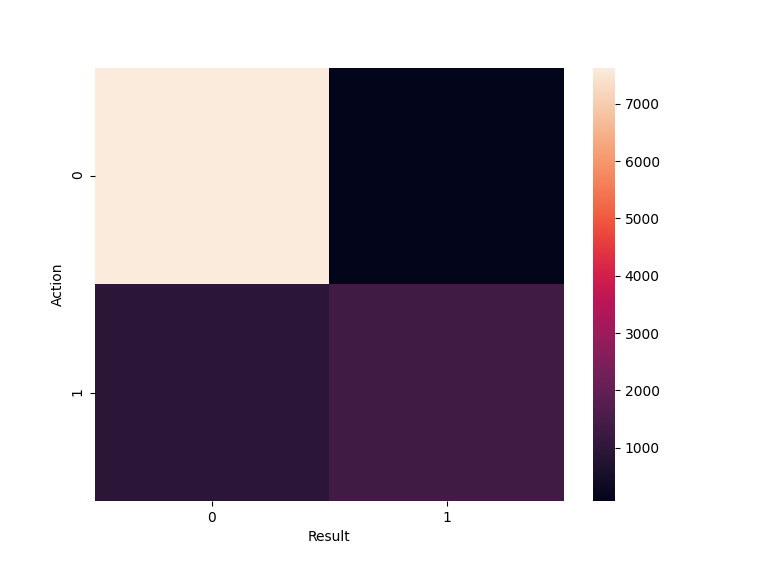

Further, we can look at the percentage of patients cured by trick vs treatment  
Percentage of patients that recovered
- with placebo treatment: 0.89%
- with drug treatment: 58.81%

This implies that the experimental drug does work to some extent, as more than half of the treated patient recovered, while only 0.9% got better without. However, it should be taken into consideration that less than 25% of the patients got treated with the experimental drug.

#### Correlation between symptoms, actions and outcome
The correlations between the symptoms, actions and outcome can give us an intuition on what importance they have for a patient recovering. If the correlation is significant, it means that the factors are strongly connected (e.g. that the symptoms has an effect on the outcome).

The correlations are as follows:

|  |symptoms|actions|outcome|
|--|---------|--------|-------|
|**symptoms**|1.000000|0.555412|0.40247| 
|**actions**|0.555412|1.000000|0.69811|
|**outcome**|0.402470|0.698110|1.00000|

To easier see the strength of the correlations, we also made a colormap:
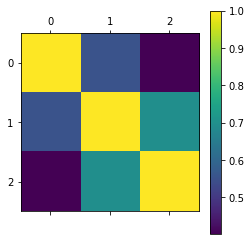

The strong correlation between actions and outcome is not a big surprise. We have already seen that the placebo has close to no effect on the disease. The correlation between symptom and actions and the correlation between symptoms and outcome are both under what we define as high correlation (0.6), but it seems that the symptoms has some effect on both action and outcome.

To further examine the relationship between the symptoms, actions and outcome, we can make two density histograms: one with outcome for treated patiens, divided into symptom categories, and one with the outcome for the untreated (placebo) patiens, also divided into symptom categories.
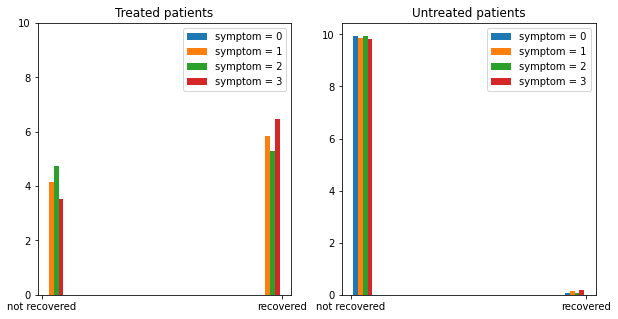

What comes very obvious from the plot, is that none of the patients with symptoms = 0 are treated with the drug. Also, patients with symptoms = 3 seems to be more likely to recover.

#### Further investigations
Further investigations could be to look into what the 69 people that recovered without treatment have in common with the 1352 that recovered with the drug treatment. Another interesting point will be to look at what the 946 patients that did not recover by the medication have in common, and thereby see whether we can deduct any indications as to who the drug is the most effective.

### The features for different actions and outcomes
To further investigate where the drug has a positive effect on the patients, we could examine which features are more present in the different action and outcomes.

Therefore we have made a histogram of the percentage of the cases where feature $x_i = 1$ for all the cases with the same action and outcome. The histograms were made conditional (e.g. $P(x_i=1 \mid a = 1, o = 1)$) to better observe the differences, because there is quite a different number of observations for the different cases (e.g. $(a=0, o=0) =  7633 $ and $(a=0, o=1) = 69$), which would make the percentage of total observations quite small for some cases. However, the distributions are more "flattened out" the more observations we have, which you can see in the plots. 

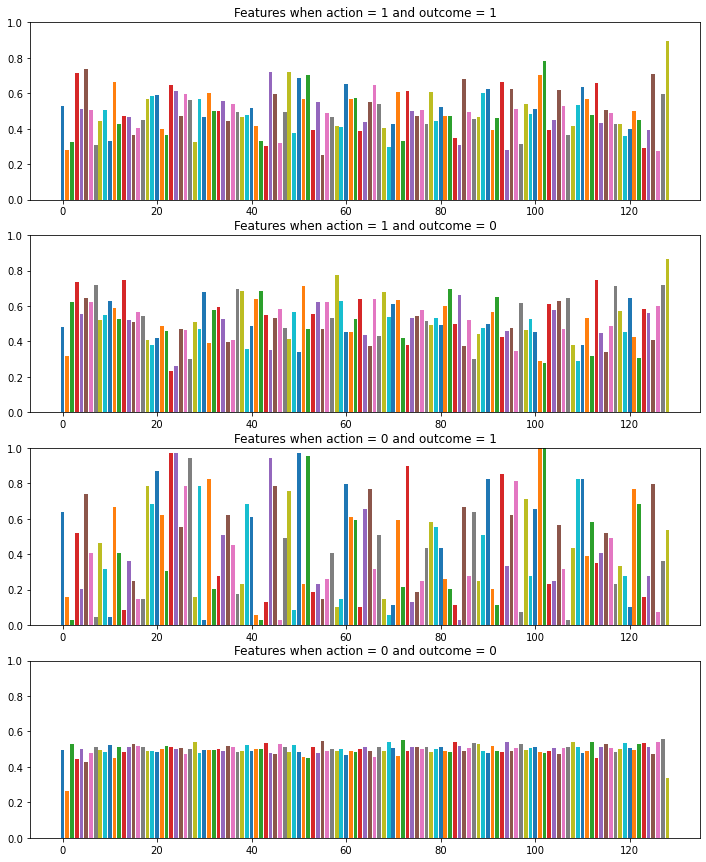


## Part 2: Improved Policies
### Exercise 1.1
To measure utility, we decided to use the average utility to measure our success, so that a larger dataset wouldn't yield a higher utility by default.

Using the given utility function  
$$ U= \sum_{t} r_t $$ 
$$ r_t \triangleq -0.1a_t + y_t $$
defined in the assignment, and then finding the average utility

$$\hat{U} = \frac{1}{T}\sum_{t=0}^T -0.1a_t + y_t $$

When running this on the historical data, we got the average utility of $\hat{U} = 0.11912$.

### Exercise 1.2
To find the error bounds on the expected utility, we'll use bootstrapping and look at the 95% confidence interval.  
We first create 1000 datasets by sampling from the original data, then calculate the expected utility for each dataset using policy.estimate_utility(). 

Looking at the 2.5 and 97.5 percentiles from the resulting datasets, we get the 95% confidence interval $[0.113, 0.125]$. 

The average utility we estimated from the historical data, 0.11912, is thereby within the 95% confidence interval.

### Exercise 2.1
To find an improved policy, we chose to use the Logistic Regression model, as this is a good baseline model for classification problems. Our implementation can be found in **lr_recommender.py**. As for the solver, we tried newton-cg, lbfgs and liblinear. While liblinear provided a slightly better utility than lbfgs, it is prone to get stuck (hence it is no longer the default solver in Scikit-learn versions > 0.22.0), therefore we decided to go with the lbfgs solver. 

Our new policy, $\hat{\pi}$, is as suggested in the assignment description: for each observation $x_t$ we choose the action $a_t$ that yields the highest reward score - either expected reward from using placebo ($a=0$) or expected reward using the actual drug ($a=1$) - and thereby maximize out utility.

The policy is implemented as follows:
***
```
if E_u(placebo) > E_u(drug):
    <recommending action 0>
else:
    <recommending action 1>
```
***

### Exercise 2.2
The expected utility estimates from the logistic regression model with the different solvers were as follows:
- liblinear: 0.38  
- lbfgs: 0.37190  
- Newton-cg: 0.37189

Since we chose the lbfgs solver, our expected average utility using the new policy $\hat{\pi}$, is
$$E(\hat{U}_{LR}) = 0.37190 $$

#### Additional models
Out of curiosity, we also implemented a neural network classifier which can be found in mlp_recommender.py. When implementing this, we also scaled our data with scikit-learn StandardScaler to normalize it.  
The MLP Classifier outpreformed the Logistic Regression Classifier and yielded an expected average utility of
$$E(\hat{U}_{MLP}) = 0.427$$
  
All the estimations (including the confidence interval) can be reproduced by running **TestRecommender.py**, though you might have to edit the path to the datasets. We also used np.random.seed(42) for reproducibility.

## Part 3: Adaptive Experiment Design  
### Exercise 3.1  
When we created the HistoricalRecommender class, we decided to use a KNN classifier with n_neighbours=1. Our reasoning behind this, is that we want to estimate the historical policy by finding the patient in the historical data that is most similar to the newly observed patient and give them the same treatment. Running the Test Bench on our HistoricalRecommender yields an expected utility of 0.132. This is slightly higher than than the original policy. Next we did bootstrapping in the same fashion as with the original policy to create a confidence interval. Looking at the 2.5 and 97.5 percentile we got a CI of \[0.088, 0.128\]. This is somewhat wider than the first interval, but the expected utility from exercise 1.1 of 0.11912 is covered within this confidence inteval. Hence, we believe that we have sufficiently estimated the original historical policy $\pi_0$  

### Exercise 3.2  
For this exercise we started by using our MLP Classifier from exercise 2. We implemented the recommend function to estimate the reward from giving a patient placebo and the reward for giving them a treatment, and chose the action that yielded the highest reward. We got an estimated utility of 0.4524. To further investigate this number, we once again made a 95\% confidence interval to see the expected error bounds. The 95% CI was \[0.339, 0.427\]. As we can see, our estimated utility of 0.4524 is outside of the confidence interval, which means it might be too high. We could try and change the seed for our policy, but decided to keep it for better reproducibility.  

### Exercise 3.3
The HistoricalRecommender is slightly better than our historical policy. Our ImprovedRecommender is also slightly better than our mlp_recommender from the historical data. However, the increase in utility is still relatively low. HistoricalRecomender only gives treatment to 249 patients out of 1000, while our ImprovedRecommender using MLP Classifier gives treatment to 526. This is a significant difference and since the best utility is for MLP Classifier we can reason that more than 249 patients need treatment and that the HistoricalRecommender gives to many patients placebo. 

Our data might not have egnough sample for a neural network to perform optimal. A neural network need a lot of data to be tuned so with more samples this method would probably preform better. 

### Exercise 4.1
We implemented an AdaptiveRecommender using the same code as our ImprovedRecommender, but we added an observe function that refitted the model for each new patient that was observed. This increased our expected utility to 0.4621, which again is a slight improvement to our previous results. We wanted to create a confidence interval for this as well, but the AdaptiveRecommender is computationally demanding, as it refits the model for each new patient it observes.  

### Exercise 4.2
Our first experiment for the additional set of treatments was to add some functionality to our ImprovedRecommender and AdaptiveRecommender, where it would calculate the expected reward for each of the 129 different treatments for each patient, and choose the treatment with the highest reward. These clases can be found in ImprovedRecommenderBig and AdaptiveRecommenderBig. This led to the model only recommending treatment 0, 1 and 2. The same goes for our AdaptiveRecommender. However, adding different treatments as an option increased our expected utility drastically. Our ImprovedRecommenderBig got an expected utility of 0.626, while AdaptiveRecommenderBig got an utility of 0.60. This is most likely because we expect more utility from treating more patients, and with more treatments available, we are more likely to treat patients. However, for the AdaptiveRecommenderBig, it will assign medication to a lot of people who won't benefit from it. During the run over 1000 patients, the action 0 becomes more and more rare.  
Our next approach was to implement Thompson Bandit, so we could explore the other treatments. We ran the Thompson Bandit with n 10000 (we also tried n=100000, but it only got more skewed towards treatment 2), and got the following results:  

| Times used | Treatment                                   |
|------------|---------------------------------------------|
|    8313    |                      2                      |
|     373    |                      1                      |
|     16     |                     115                     |
|     15     |                     127                     |
|     14     | 86, 46, 98, 52, 71, 4, 7, 20                |
|     13     | 49, 55, 42, 33, 30, 59, 93, 117             |
|     12     | 27, 13, 73, 88                              |
|     11     | 37, 38, 116, 85, 19, 57, 69, 60, 43, 26, 87 |  

From the Thompson Bandit, we see that treatment 2 and 1 clearly are the most popular. What we want to do next, is experiment with treatment 115 and 127, to see whether these might be beneficial for someone with a particular gene. We implemented a function in Test_additional_treatments_Recommender.py that gives a fixed treatment to 10.000 patients, stores the gene data of the ones who gets cured and take a look at what genes they have in common. Looking at treatment 115 first, 302 out of 10.000 patients got cured with this treatment. Looking at the patients genes, these are the most common:  

| Gene | Number of treated patients |
|------|----------------------------|
|  102 |             298            |
|  23  |             288            |
|  101 |             285            |
|  44  |             281            |
|  24  |             280            |
|  50  |             279            |  

Next we'll have a look at treatment 127. With this treatment, 304 out of 10.000 got cured with the treatment. Looking at the patients genes, these are the most common:  

| Gene | Number of treated patients |
|------|----------------------------|
|  102 |             303            |
|  44  |             294            |
|  24  |             291            |
|  50  |             288            |
|  52  |             288            |
|  101 |             284            |  

What is interesting to note here, is that gene 102 seems to be the most common gene in both patient groups. There might be a few reasons for this. First, Gene 102 might be a very common gene among humans. There does not need to be a correlation between the treatment working and people having this gene. Second, this might be a gene that increases the likelihood of getting cured regardless of treatment.  
We take a closer look at the 10.000 patients. It appears that 5034 of the patients possess gene 102. This is just over half of the patients, which justifies closer inspection as everyone but a few with this gene got cured. We try and administer placebo to the 10.000 patients and observe the results. 113 out of 10.000 got cured, 102 of which had Gene 102. We would also like to point out that Gene 44 and 24 seems to be related in some way as it's also making the top cut every time. Now, even though it seems that the ones with Gene 102 gets better irregardless, we must still pay attention to the fact that almost 3 times as many got cured with the treatments than without. So for one last shot at finding a gene specific treatment, we see how the patients with these genes responds to the general treatment. Administering Treatment 2 to everyone cures 5846 out of 10.000 patients. However, only 3483 out of these possess Gene 102. We then try to administer treatment 127 to all patients that possess the combination of Gene 102, 44, 24, 50, 52 and 101, while everyone else gets the general treatment. This results in 5019 people getting cured, 2656 of which has Gene 102. It still looks very much like the general treatment is the better one. Just to make sure, however, we'll do the same for Treatment 115. Switching out Gene 52 for Gene 23, we administer Treatment 115 to everyone with the combination specified earlier. This yields a result of 5086 people getting cured, while 2723 of these possess the gene combination. We could also look into how many people got cured with the specific combination, but that seems pointless as there are less people getting treated in general.
 
  
We wanted to do another approach as well before giving up on the fixed treatments. What if we look at remaining 4154 that does not get treated with Treatment 2, and find a treatment that works well on them? We ran some experiments for Gene 72, 55 and 83, as these seems to be the most prevalent amongs patients that doesn't get cured with Treatment 2. Our first observation is that Treatment 1 seems to work slightly better on these patients than Treatment 2. As for the other treatments, they don't really seem to work except for a very small number of patients with these genes. An interesting find, is that if we administer Treatment 1 to patients with Gene 72, and Treatment 2 to everyone else, we actually end up with 6931 cured patients, instead of 5846 which we had previously. This is a significant increase, and it's enough that we'll want to include this in our policy. We tried implementing a forced action into our policies where they would always choose Treatment 1 for Gene 72, but this actually lowered our expected utility. We think this might be because our policy has found a better way of treating people with this gene. 

## Final Analysis
We decided to implement our final_analysis() in the TestRecommender so that it runs all the different recommenders from our report. It then posts a report to the terminal comparing a few different scores.  
0. Utility for historical data: 0.11912   
1. Utility for LogisticRegressionRecommender on historical data: 0.38   
2. Utility for MlpRecommender on historical data: 0.427  
3. Utility for HistoricalRecommender on new patients: 0.1221  
4. Utility for ImprovedRecommender on new patients: 0.4702  
5. Utility for ImprovedRecommender on new patients, with additional treatments: 0.6291  
6. Utility for AdaptiveRecommender on new patients: 0.4573  
7. Utility for AdaptiveRecommender on new patients, with additional treatments: 0.6102  
The best policy appears to be number 5  
It yields 0.50998 more expected utility than the historical policy.  
This is an increase of 528.123 percent!  

From our experiments in Exercise 4.2, we can conclude that Treatment 2 looks more promising than Treatment 1, but doesn't appear to be that much better. In fact, there only seems to be an increase in about 10\% from 5342 to 5846 patients cured when administering one treatment to 10.000 patients. Further, we did not deduct any genes that might work better with certain treatments, we did however, find some genes that seems to be resistant against treatments, and some that appear to be more easily treated. As of now, we would suggest administering Treatment 2 on a regular basis, but it would be worth looking into the genes mentioned in Exercise 4.2 in future work.

## Fairness 
Naturally, we want our policy to be fair. There are several aspects of fairness we should investigate to determine if our policy could be violating any fairness principles. We do not know whether the policy when collecting the data was fair, i.e if the selection of who got treated was fair. If that was the case it will have an impact of how fair our methods are. 

Primarily, our goal would be to avoid discrimination against patients based on their sensitive attributes. In our data, the features *gender* and *whether a person smokes* can be considered sensitive. If our model is using a patients gender to determine whether they should recieve treatment, it would be a grave fairness violation. Removing the gender as a covariate could be a solution. 

The *smoking* feature is a little more tricky, because the smoking could cause damage to the body, resulting in worsened chances of recovery. This means it could be an important covariate in the prediction of recovery, and thereby our utility. Thus, we have to try balancing between the fairness and the utility. A way of compromising between the two could be to assign a ligther weight to the smoking feature -- and thereby not excluding it totally, but making sure that other factors are considered as well. 

Another fairness priniciple is who gets treated first if there is limited treatments, or a lot of patients at the same time. It can be more fair to give treatment to those who are sickest first, from our data we are given no such information so we can not take that into account in our policy. Instead, our model will focus on choosing the cases that are more likely to give a good outcome, which could mean that we are only treating patients with mild symptoms and better chances at recovering. 

Satisfying all fairness principles, and also making sure our utility is satisfactory, could be an impossible task.


## Privacy
To have ones data protected in regards to privacy is a human right, so we need to make sure this is being done with our policy.

"*No one shall be subjected to arbitrary interference with his
privacy, family, home or correspondence, nor to attacks
upon his honour and reputation.
Everyone has the right to the protection of the law against
such interference or attacks*"
-*United Nations Declaration of Human Rights, 1948, Article 12*

Since we are in Norway we also need to follow GDPR.  The data in our dataset is already anonimyzed some since we do not have patients names and other easily identified variables.

Medical information about a patient is a serious privacy concern, and making sure this information is not misplaced or misused is very important. The most sensitive identifiers would most likely be the patient's gender and whether they smoke, also perhaps connecting this to their symptoms or recovery status. This information could be gathered and used as a part of identification of a person. 

Furtheron, a patient's genes could possibly be quasi-indentifiers, but in this dataset, the genes are represented anonymously without any indications about what genes they are, and it is only listed whether they are present or not. Using this to identify an individual should be fairly difficult.

For future patients, it is important that the information maintains the same level of anonymity as the historical data. When collecting more data it is a good idea to consider adding some noise, but also make sure that it does not have unintended consequenses on the treatment such that patients who might have been cured get more sick instead, becase of some changes in gene combintation. 

It is important that we store our data in a place not easily accessible by intruders. If someone unwanted got our data, even if it is not possible to identify patients, they might use it in a way our patients have not agreed on when the data was collected. It is also bad if we are a medical company wanting to test possible treatments on different diseases and another company could use our data that is expensive to collect.

# Sources
- Christos Dimitrakakis: *Machine learning in science and society* (Aug. 2020). PDF: https://github.com/olethrosdc/ml-society-science/blob/master/notes.pdf

- Friedler, Scheidegger and Venkatasubramanian: *The (Im)possibility of fairness.* (Sep. 2016). PDF: https://arxiv.org/pdf/1609.07236.pdf
- Ziyuan Zhong: *A Tutorial on Fairness in Machine Learning* (Oct. 2018). URL: https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb
- Domingo-Ferrer, Sánchez and Soria-Comas: *Database Anonymization: Privacy Models, Data Utility and Microaggregation-based Inter-model Connections* (Jan. 2016). PDF-download: https://www.researchgate.net/publication/290229262_Database_Anonymization_Privacy_Models_Data_Utility_and_Microaggregation-based_Inter-model_Connections
-  Jason Brownlee, "How to Perform Feature Selection with Categorical Data" (Nov. 2019, read Nov. 2020) https://machinelearningmastery.com/feature-selection-with-categorical-data/
- Raheel Shaikh, "Feature Selection Techniques in Machine Learning with Python" (Oct. 2018, read Nov. 2020) https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e